## Классификация изображений

### План семинара:

1) Обучим сверточную сеть в задаче классификации изображений и посмотрим на полученные фильтры свёрток

2) Добавим аугментацию

3) Усложняем архитектуру сети для улучшения качества

In [1]:
  # !pip install wandb
import warnings

import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000. Загрузим его аналогично тому, как мы загружали MNIST на предыдущих занятиях.

In [3]:
batch_size = 16
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./cifar", 
    train=True,                             
    download=True, 
    transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root="./cifar", 
    train=False,
    download=True, 
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=1
)

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


In [5]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

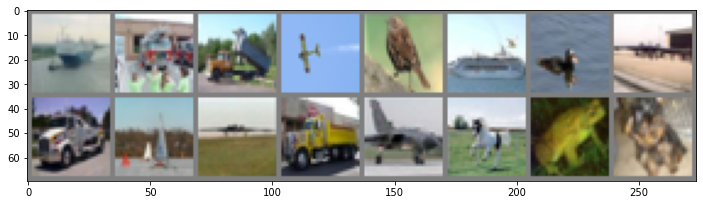

In [5]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

В качестве бейзлайна возьмем сверточную сеть, состоящую из 1 VGG блока.

VGG блок состоит из двух последовательных сверточных слоев с нелинейностью ReLU между ними, а затем max-pooling. В VGG используются маленькие фильтры размера 3x3 и паддинг

### В качестве бейзлайна постройте следующую архитектуру:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3 и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 5x5 и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами и Softmax

In [8]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*16*16, 128),
            nn.ReLU()
        )

        self.linear_softmax_stack = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, x):
        # x: (batch_size; n_channels; hight; width)
        # # your code here
        x = self.vgg(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        logits = self.linear_softmax_stack(x)
        return logits

In [7]:
model_baseline_test = ModelBaseline().to('cpu')
model_baseline_test

ModelBaseline(
  (vgg): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear_softmax_stack): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

## Задание: допишите цикл обучения

In [10]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=25):    
    for epoch in range(n_epochs):
        train_epoch_loss = torch.empty(0).cuda()
        accuracy_val, precision_val, recall_val, f1_val = [], [], [], []

        model.train()

        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0) / labels.size(0)))

        wandb.log(
            {
                'mean loss per epoch': train_epoch_loss.mean()
            }
        )

        # валидация
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)

                pred_classes = torch.argmax(y_pred, dim = 1).cpu().numpy()
                labels_numpy = labels.cpu().numpy()

                accuracy = accuracy_score(labels_numpy, pred_classes)
                precision = precision_score(labels_numpy, pred_classes, average = 'macro')
                recall = recall_score(labels_numpy, pred_classes, average = 'macro')
                f1 = f1_score(labels_numpy, pred_classes, average = 'macro')

                accuracy_val.append(accuracy)
                precision_val.append(precision)
                recall_val.append(recall)
                f1_val.append(f1)

                wandb.log(
                    {
                        'accuracy per batch': accuracy,
                        'precision per batch': precision,
                        'recall per batch': recall,
                        'f1 per batch': f1
                    }
                )

            wandb.log(
                {
                    'mean accuracy': np.array(accuracy_val).mean(),
                    'mean precision': np.array(precision_val).mean(),
                    'mean recall': np.array(recall_val).mean(),
                    'mean f1': np.array(f1_val).mean()
                }
            )

In [9]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

In [ ]:
config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG",
    activation = 'relu',
    epoch = '25',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "baseline",
    config=config,
)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 25)

## Задание:

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

[Почитать про разные функции активации можно здесь](https://mlfromscratch.com/activation-functions-explained/#/)

In [14]:
class ModelWithLeakyReLUActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, kernel_size=5, padding=2),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.flatten = nn.Flatten()

    self.linear_leakyrelu_stack = nn.Sequential(
        nn.Linear(16*16*16, 128),
        nn.LeakyReLU()
    )

    self.linear_softmax_stack = nn.Sequential(
        nn.Linear(128, 10),
        nn.Softmax()
    )

  def forward(self, x):
    # x: (batch_size; n_channels; hight; width)
    # # your code here
    x = self.vgg(x)
    x = self.flatten(x)
    x = self.linear_leakyrelu_stack(x)
    logits = self.linear_softmax_stack(x)
    return logits
        
        
model_baseline1 = ModelWithLeakyReLUActivation().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG",
    activation = 'leaky_relu',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "diff_activate_leaky_relu",
    config=config,
)

train(model_baseline1, criterion, optimizer, train_dataloader, val_dataloader)

In [7]:
class ModelWithELUActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ELU(2),
        nn.Conv2d(16, 16, kernel_size=5, padding=2),
        nn.ELU(2),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.flatten = nn.Flatten()

    self.linear_elu_stack = nn.Sequential(
        nn.Linear(16*16*16, 128),
        nn.ELU(2)
    )

    self.linear_softmax_stack = nn.Sequential(
        nn.Linear(128, 10),
        nn.Softmax()
    )

  def forward(self, x):
    # x: (batch_size; n_channels; hight; width)
    # # your code here
    x = self.vgg(x)
    x = self.flatten(x)
    x = self.linear_elu_stack(x)
    logits = self.linear_softmax_stack(x)
    return logits
        
        
model_baseline2 = ModelWithELUActivation().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG",
    activation = 'elu',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "diff_activate_elu",
    config=config,
)

train(model_baseline2, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=25)

In [14]:
class ModelWithLeakySELUActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.SELU(),
        nn.Conv2d(16, 16, kernel_size=5, padding=2),
        nn.SELU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.flatten = nn.Flatten()

    self.linear_selu_stack = nn.Sequential(
        nn.Linear(16*16*16, 128),
        nn.SELU()
    )

    self.linear_softmax_stack = nn.Sequential(
        nn.Linear(128, 10),
        nn.Softmax()
    )

  def forward(self, x):
    # x: (batch_size; n_channels; hight; width)
    # # your code here
    x = self.vgg(x)
    x = self.flatten(x)
    x = self.linear_selu_stack(x)
    logits = self.linear_softmax_stack(x)
    return logits
        
        
model_baseline3 = ModelWithLeakySELUActivation().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline3.parameters(), lr=0.001, momentum=0.9)

In [ ]:
config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG",
    activation = 'selu',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "diff_activate_selu",
    config=config,
)

train(model_baseline3, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=25)

# 2. Аугментация

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения

In [3]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./cifar", 
    train=True,                             
    download=True, 
    transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root="./cifar", 
    train=False,
    download=True, 
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=16,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=16,
    shuffle=False, 
    num_workers=1
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


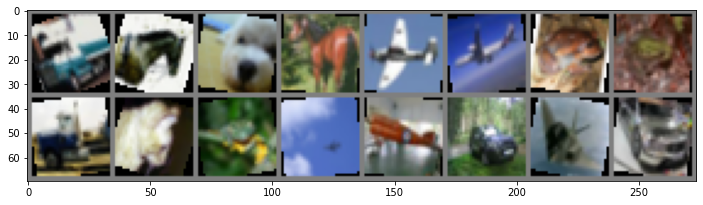

In [6]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [12]:
model_base = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

In [ ]:
config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG_augmentation",
    activation = 'relu',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "augmenatation_baseline",
    config=config,
)

train(model_base, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=25)

# 3. Как улучшить качество модели?

Особенность VGG блока заключается в том, что повышение качества работы сети достигается увеличением числа последовательных блоков. При этом число фильтров в каждом новом блоке в два раза больше, чем в предыдущем. Давайте попробуем объединить 3 VGG блока.

## **Dropout**

Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим будем использовать Dropout

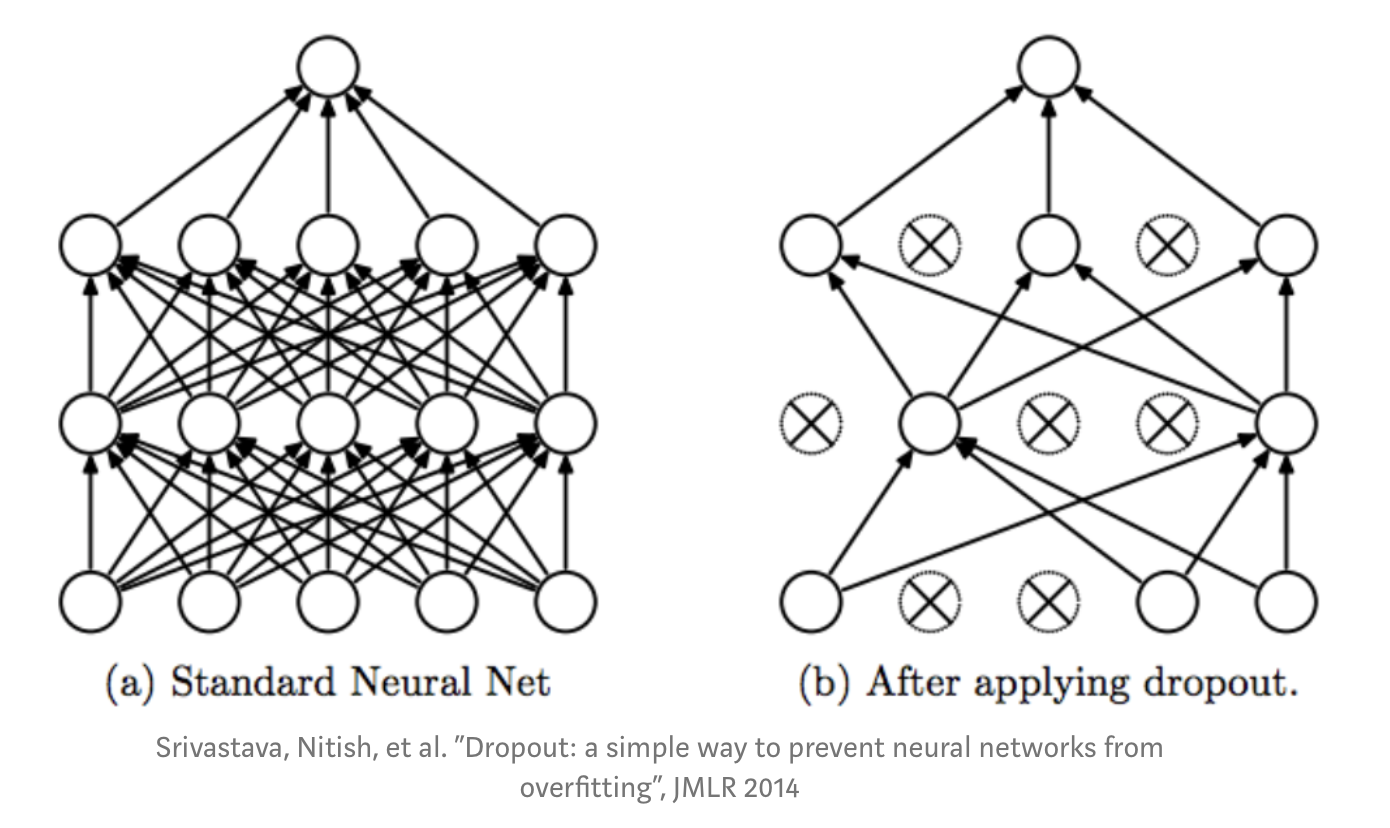

Добавим Dropout с параметром 0.2 после каждого VGG блока и после 1 полносвязного слоя и его нелинейности.

для ускорения и стабилизации обучения добавим [BatchNorm](https://habr.com/ru/post/309302///) после каждого сверточного слоя и после 1 полносвязного слоя
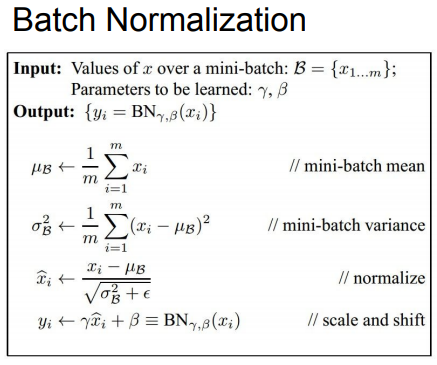


In [15]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
)

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

config = dict (
    learning_rate = 0.001,
    architecture = "CNN_with_VGG_augmentation",
    activation = 'relu',
    momentum = 0.9,
    dataset_id = "CIFAR10",
)

wandb.init(
    project="Sem-03",
    name = "BN_dropout_baseline",
    config=config,
)

train(model, criterion, optimizer, train_dataloader, val_dataloader)